In [1]:
import pandas as pd

In [2]:
hotel=pd.read_csv('hotel.csv')
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [5]:
hotel.loc[1,:]

hotel                             Resort Hotel
is_canceled                                  0
lead_time                                  737
arrival_date_year                         2015
arrival_date_month                        July
arrival_date_week_number                    27
arrival_date_day_of_month                    1
stays_in_weekend_nights                      0
stays_in_week_nights                         0
adults                                       2
children                                   0.0
babies                                       0
meal                                        BB
country                                    PRT
market_segment                          Direct
distribution_channel                    Direct
is_repeated_guest                            0
previous_cancellations                       0
previous_bookings_not_canceled               0
reserved_room_type                           C
assigned_room_type                           C
booking_chang

In [95]:
X=hotel.copy()
y=hotel.pop('is_canceled')
X['arrival_date_month']=X['arrival_date_month'].map({'January':1,
'February':2, 'March':3,'April':4, 'May':5, 'June':6, 'July':7,
'August':8, 'September':9, 'October':10,'November':11, 'December':12})
features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

In [100]:
#Preprocess the numerical columns
transform_num=make_pipeline(SimpleImputer(strategy='constant'),
                           StandardScaler())
#Preprocess the categorical columns
transform_cat=make_pipeline(SimpleImputer(strategy='constant'
                                          ,fill_value='NA'), 
                            OneHotEncoder(handle_unknown='ignore'))
#Combine two into preprocessor
preprocessor=make_column_transformer((transform_num,features_num),
                                    (transform_cat,features_cat))
X_train,X_test,Y_train,Y_test=train_test_split(X,y,stratify=y,test_size=0.2)
X_train=preprocessor.fit_transform(X_train)
X_test=preprocessor.transform(X_test)
in_shape=X_train.shape[1]

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Activation,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
model =Sequential([
    Dense(X_train.shape[1],activation='relu'),
    Dense(units=256,activation='relu'),
    BatchNormalization(),
    Dense(units=256,activation='relu'),
    BatchNormalization(),
    Dense(units=1,activation='sigmoid')
])

In [121]:
model.compile(optimizer='adam',loss='binary_crossentropy'
              ,metrics=['binary_accuracy'])

Epoch 1/200
187/187 [==============================] - 5s 16ms/step - loss: 0.4329 - binary_accuracy: 0.7949 - val_loss: 0.4931 - val_binary_accuracy: 0.7964
Epoch 2/200
187/187 [==============================] - 3s 15ms/step - loss: 0.3850 - binary_accuracy: 0.8205 - val_loss: 0.4144 - val_binary_accuracy: 0.8103
Epoch 3/200
187/187 [==============================] - 2s 13ms/step - loss: 0.3692 - binary_accuracy: 0.8290 - val_loss: 0.3848 - val_binary_accuracy: 0.8235
Epoch 4/200
187/187 [==============================] - 3s 16ms/step - loss: 0.3598 - binary_accuracy: 0.8340 - val_loss: 0.3751 - val_binary_accuracy: 0.8259
Epoch 5/200
187/187 [==============================] - 3s 14ms/step - loss: 0.3515 - binary_accuracy: 0.8370 - val_loss: 0.3739 - val_binary_accuracy: 0.8270
Epoch 6/200
187/187 [==============================] - 3s 14ms/step - loss: 0.3438 - binary_accuracy: 0.8413 - val_loss: 0.3689 - val_binary_accuracy: 0.8290
Epoch 7/200
187/187 [==============================]

<AxesSubplot:title={'center':'Accuracy'}>

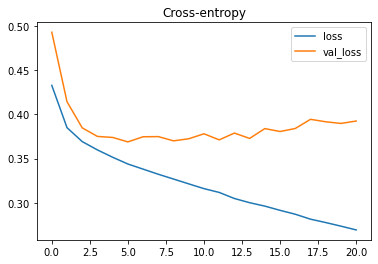

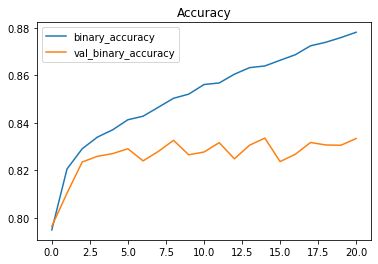

In [122]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping]
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")